In [1]:
%reset

import keras
import pickle as pk
import matplotlib.pyplot as pl
import matplotlib
import numpy as np
import pdb
import sklearn.model_selection

%matplotlib inline

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
# The neural network architecture that we'll use in the example below is based on:
# See https://github.com/eriklindernoren/Keras-GAN/blob/master/context_encoder/context_encoder.py

Refs
-Context encoder: https://arxiv.org/abs/1604.07379

-You might find the answer in this paper "Towards principled methods for training generative adversarial networks" (https://arxiv.org/pdf/1701.04862.pdf). It has a part explaining why the generator's gradient vanishes as the discriminator gets stronger.

-Training GANs https://machinelearningmastery.com/practical-guide-to-gan-failure-modes/

-https://github.com/soumith/ganhacks

## Data location and dimensions

In [3]:
#The data are "cutouts" from full-sky maps made from observations by the Planck satellite.
#These maps were constructed at an observing frequency of 857 GHz
data_dir = './cutout_data/'
# this file contains some cutouts that are "off star", i.e. centered at random locations on the sky
# and not on star locations
#offstar_file = 'cutouts_1000offstarfirstpass_01.pk'
offstar_file = 'cutouts_1000offstarmultifreq_01.pk'

#The iniital cutouts have a dimension of 200x200.  We'll reduce the dimension to dim_reduced x dim_reduced
#to speed up the analysis
dim_reduced = 32
#We're going to mask out a small part of the center of the cutout with dimension dim_mask x dim_mask
dim_mask = 8

#Testing the angular size of the mask
print("angular size of mask (arcmin) = ", dim_mask*1.5)
fwhm_545 = 4.7
sigma_545 = 4.7/np.sqrt(8.*np.log(2))
print("angular size of mask (psf at 545) = ", dim_mask*1.5/sigma_545)

angular size of mask (arcmin) =  12.0
angular size of mask (psf at 545) =  6.01230649795136


## Load the cutout data

In [4]:
#load the data
cutout_data = pk.load(open(data_dir + offstar_file, 'rb'))

# treat log of images as data
do_log = True 

print(cutout_data.keys())
ll = cutout_data['l'] # galatic longitude of the cutout
bb = cutout_data['b'] # galactic latitude of the cutout
if (do_log):
    cutouts_orig = np.log(cutout_data['cutouts'].transpose((1,2,3,0)))
if (not do_log):
    cutouts_orig = cutout_data['cutouts'].transpose((1,2,3,0))

print(cutouts_orig.shape)


dict_keys(['planck_files', 'cutouts', 'l', 'b'])
(1000, 200, 200, 2)


## Plot a few cutouts

Text(0.5, 1.0, '857')

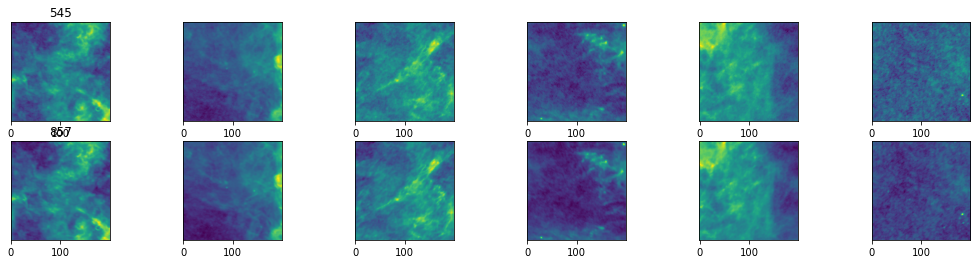

In [5]:
nplots = 6
fig, ax = pl.subplots(2,nplots, figsize = (nplots*3., 4))
for ii in range(0,nplots):
    ax[0,ii].imshow(cutouts_orig[ii,:,:,0])
    ax[1,ii].imshow(cutouts_orig[ii,:,:,1])
    #ax[ii].xaxis.set_visible(False)
    ax[0,ii].yaxis.set_visible(False)
    ax[1,ii].yaxis.set_visible(False)
ax[0,0].set_title('545')
ax[1,0].set_title('857')

## Reduce the dimensionality of the cutouts, and optionally add more

num to fit =  6
(36000, 32, 32, 2)


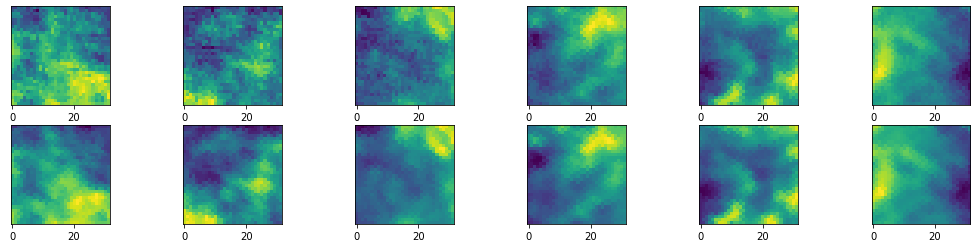

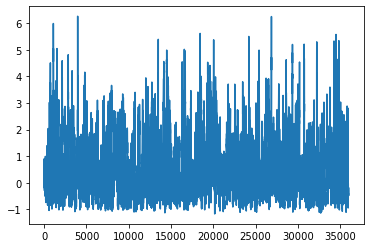

In [6]:
#Select only the center region of the cutouts
orig_dims = cutouts_orig.shape
ncutouts = orig_dims[0]
nrow = orig_dims[1]
ncol = orig_dims[2]
nfreq = orig_dims[3]

#Centers of original cutouts
if (0):
    min_ind = int(nrow/2 - dim_reduced/2)
    max_ind = int(nrow/2 + dim_reduced/2)
    cutouts_orig_red = cutouts_orig[:,min_ind:max_ind, min_ind:max_ind, :]
if (1):
    num_to_fit = int(np.floor(nrow/dim_reduced))
    print("num to fit = ", num_to_fit)
    cutouts_orig_red = np.zeros((ncutouts*num_to_fit**2, dim_reduced, dim_reduced, nfreq))
    for ii in range(0,ncutouts):
        for rowfit in range(0,num_to_fit):
            for colfit in range(0,num_to_fit):            
                this_index = ii*(num_to_fit**2) + rowfit*num_to_fit + colfit
                min_row = rowfit*dim_reduced
                min_col = colfit*dim_reduced
                cutouts_orig_red[this_index] = \
                cutouts_orig[ii,min_row:min_row + dim_reduced,min_col:min_col + dim_reduced,:]
print(cutouts_orig_red.shape)
                
nplots = 6
fig, ax = pl.subplots(2,nplots, figsize = (nplots*3., 4))
for ii in range(0,nplots):
    ax[0,ii].imshow(cutouts_orig_red[ii,:,:,0])
    ax[1,ii].imshow(cutouts_orig_red[ii,:,:,1])
    
    #ax[ii].xaxis.set_visible(False)
    ax[0,ii].yaxis.set_visible(False)
    ax[1,ii].yaxis.set_visible(False)
fig, ax = pl.subplots(1,1)
ax.plot(cutouts_orig_red[:,0,0,0])
    
#fig.savefig('./network_out/example_images.png')

## Test train split

In [7]:
cutouts_train, cutouts_test = sklearn.model_selection.train_test_split(cutouts_orig_red, test_size=0.2)
print(cutouts_train.shape)
print(cutouts_test.shape)
print(dim_reduced)

print("min val = ", np.min(cutouts_orig_red))
print("max val = ", np.max(cutouts_orig_red))

(28800, 32, 32, 2)
(7200, 32, 32, 2)
32
min val =  -1.420618401650951
max val =  9.91913096014962


## Set up the neural network

In [8]:
#do_gan = True

from __future__ import print_function, division

from keras.datasets import cifar10
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, GaussianNoise
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers import MaxPooling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras import losses
from keras.utils import to_categorical
import keras.backend as K

import matplotlib.pyplot as plt

import numpy as np

class ContextEncoder():
    def __init__(self):
        self.img_rows = dim_reduced
        self.img_cols = dim_reduced
        self.mask_height = dim_mask
        self.mask_width = dim_mask
        self.channels = nfreq
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.missing_shape = (self.mask_height, self.mask_width, self.channels)

        optimizer_discriminator = Adam(0.00002, 0.5) #0.0002
        optimizer_generator = Adam(0.00002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer_discriminator,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()
        masked_img = Input(shape=self.img_shape)
        gen_missing = self.generator(masked_img)
        
        # For the combined model we will only train the generator
        # why do we do this?
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines
        # if it is generated or if it is a real image
        valid = self.discriminator(gen_missing)

        # The combined model  (stacked generator and discriminator)
        # Trains generator to fool discriminator
        self.combined = Model(masked_img , [gen_missing, valid])
        self.combined.compile(loss=['mse', 'binary_crossentropy'],
            loss_weights=[0.999, 0.001],
            optimizer=optimizer_generator)

    def build_generator(self):

        model = Sequential()
        
        if (0):
            # Encoder
            model.add(Conv2D(4, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
            # rows/strides, cols/strides, 32 filters
            model.add(LeakyReLU(alpha=0.2))
            model.add(BatchNormalization(momentum=0.8))

            model.add(Conv2D(8, kernel_size=3, strides=2, padding="same"))
            # rows/strides**2, cols/strides**2, nfilters = 64
            model.add(LeakyReLU(alpha=0.2))
            model.add(BatchNormalization(momentum=0.8))

            model.add(Conv2D(16, kernel_size=3, strides=2, padding="same"))
            # rows/strides**3, cols/strides**3, nfilters = 128
            model.add(LeakyReLU(alpha=0.2))
            model.add(BatchNormalization(momentum=0.8))

            model.add(Conv2D(32, kernel_size=3, strides=2, padding="same"))
            # rows/strides**3, cols/strides**3, nfilters = 128
            model.add(LeakyReLU(alpha=0.2))
            model.add(BatchNormalization(momentum=0.8))


            #model.add(Conv2D(256, kernel_size=3, strides=2, padding="same"))
            # rows/strides**3, cols/strides**3, nfilters = 256
            #model.add(LeakyReLU(alpha=0.2))
            #model.add(BatchNormalization(momentum=0.8))

            #used 512 before
            model.add(Conv2D(64, kernel_size=1, strides=2, padding="same"))
            ## rows/strides**3, cols/strides**3, nfilters = 512
            model.add(LeakyReLU(alpha=0.2))

            model.add(Dropout(0.5))

            # Decoder
            model.add(UpSampling2D())
            model.add(Conv2D(64, kernel_size=3, padding="same"))
            model.add(Activation('relu'))
            model.add(BatchNormalization(momentum=0.8))
            model.add(UpSampling2D())
            model.add(Conv2D(32, kernel_size=3, padding="same")) #3
            model.add(Activation('relu'))
            model.add(BatchNormalization(momentum=0.8))
            model.add(Conv2D(self.channels, kernel_size=3, padding="same"))
            model.add(Activation('tanh'))
            
        if (0):
            # Encoder
            model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
            model.add(LeakyReLU(alpha=0.2))
            model.add(BatchNormalization(momentum=0.8))
            model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
            model.add(LeakyReLU(alpha=0.2))
            model.add(BatchNormalization(momentum=0.8))
            model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
            model.add(LeakyReLU(alpha=0.2))
            model.add(BatchNormalization(momentum=0.8))

            model.add(Conv2D(512, kernel_size=1, strides=2, padding="same"))
            model.add(LeakyReLU(alpha=0.2))
            model.add(Dropout(0.5))

            # Decoder
            #model.add(UpSampling2D())
            model.add(Conv2D(128, kernel_size=3, padding="same"))
            model.add(Activation('relu'))
            model.add(BatchNormalization(momentum=0.8))
            model.add(UpSampling2D())
            model.add(Conv2D(64, kernel_size=3, padding="same"))
            model.add(Activation('relu'))
            model.add(BatchNormalization(momentum=0.8))
            model.add(Conv2D(self.channels, kernel_size=3, padding="same"))
            model.add(Activation('tanh'))            
                    
        #original    
        if (1):
            # Encoder
            model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
            model.add(LeakyReLU(alpha=0.2))
            model.add(BatchNormalization(momentum=0.8))
            model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
            model.add(LeakyReLU(alpha=0.2))
            model.add(BatchNormalization(momentum=0.8))
            model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
            model.add(LeakyReLU(alpha=0.2))
            model.add(BatchNormalization(momentum=0.8))

            model.add(Conv2D(512, kernel_size=1, strides=2, padding="same"))
            model.add(LeakyReLU(alpha=0.2))
            model.add(Dropout(0.5))

            # Decoder
            model.add(UpSampling2D())
            model.add(Conv2D(128, kernel_size=3, padding="same"))
            model.add(Activation('relu'))
            model.add(BatchNormalization(momentum=0.8))
            model.add(UpSampling2D())
            model.add(Conv2D(64, kernel_size=3, padding="same"))
            model.add(Activation('relu'))
            model.add(BatchNormalization(momentum=0.8))
            model.add(Conv2D(self.channels, kernel_size=3, padding="same"))
            model.add(Activation('tanh'))            
        
        print("encoder decoder summary")
        model.summary()

        masked_img = Input(shape=self.img_shape)
        gen_missing = model(masked_img)

        return Model(masked_img, gen_missing)

    def build_discriminator(self):

        model = Sequential()

        if (0):
            model.add(Conv2D(64, kernel_size=3, strides=1, input_shape=self.missing_shape, padding="same"))
            model.add(LeakyReLU(alpha=0.2))
            model.add(BatchNormalization(momentum=0.8))
            model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
            model.add(LeakyReLU(alpha=0.2))
            model.add(BatchNormalization(momentum=0.8))
            model.add(Conv2D(256, kernel_size=3, padding="same"))
            model.add(LeakyReLU(alpha=0.2))
            model.add(BatchNormalization(momentum=0.8))
            model.add(Flatten())
            model.add(Dense(1, activation='sigmoid'))

        #original
        if (1):
            model.add(Conv2D(64, kernel_size=3, strides=2, input_shape=self.missing_shape, padding="same"))
            model.add(LeakyReLU(alpha=0.2))
            model.add(BatchNormalization(momentum=0.8))
            model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
            model.add(LeakyReLU(alpha=0.2))
            model.add(BatchNormalization(momentum=0.8))
            model.add(Conv2D(256, kernel_size=3, padding="same"))
            model.add(LeakyReLU(alpha=0.2))
            model.add(BatchNormalization(momentum=0.8))
            model.add(Flatten())
            model.add(Dense(1, activation='sigmoid'))
        print("discriminator summary")
        model.summary()
        
        img = Input(shape=self.missing_shape)
        validity = model(img)

        return Model(img, validity)

    def mask_randomly(self, imgs):
        y1 = np.random.randint(0, self.img_rows - self.mask_height, imgs.shape[0])
        y2 = y1 + self.mask_height
        x1 = np.random.randint(0, self.img_rows - self.mask_width, imgs.shape[0])
        x2 = x1 + self.mask_width

        masked_imgs = np.empty_like(imgs)
        missing_parts = np.empty((imgs.shape[0], self.mask_height, self.mask_width, self.channels))
        for i, img in enumerate(imgs):
            masked_img = img.copy()
            _y1, _y2, _x1, _x2 = y1[i], y2[i], x1[i], x2[i]
            missing_parts[i] = masked_img[_y1:_y2, _x1:_x2, :].copy()
            masked_img[_y1:_y2, _x1:_x2, :] = 0
            masked_imgs[i] = masked_img

        return masked_imgs, missing_parts, (y1, y2, x1, x2)

    def mask_center(self, imgs, do_plot = False):
        y1 = int(self.img_rows/2) - int(self.mask_height/2)
        y2 = y1 + self.mask_height
        x1 = int(self.img_rows/2) - int(self.mask_width/2)
        x2 = x1 + self.mask_width

        masked_imgs = np.empty_like(imgs)
        missing_parts = np.empty((imgs.shape[0], self.mask_height, self.mask_width, self.channels))
        min_outsidemask = np.empty((imgs.shape[0], self.channels))
        max_outsidemask = np.empty((imgs.shape[0], self.channels))
        
        #Get mask indcies
        temp = np.zeros((self.img_rows, self.img_rows))
        temp[y1:y2, x1:x2] = 1.0
        outside_mask = np.where(temp[:,:] != 1.0)
        
        for i, img in enumerate(imgs):
            masked_img = img.copy()

            do_norm = True
            if (do_norm):
                masked_img_norm = np.empty(masked_img.shape)
                for ci in range(0,self.channels):
                    min_outsidemask[i,ci] = np.min(masked_img[:,:,ci][outside_mask])
                    max_outsidemask[i,ci] = np.max(masked_img[:,:,ci][outside_mask])
                    # Normalize
                    #to (-1,1)
                    masked_img_norm[:,:,ci] = -1.0+2.*(masked_img[:,:,ci] - min_outsidemask[i,ci])/(max_outsidemask[i,ci] - min_outsidemask[i,ci])
            else:
                masked_img_norm = masked_img
                
            missing_parts[i] = masked_img_norm[y1:y2, x1:x2, :].copy()
            masked_img_norm[y1:y2, x1:x2, :] = 0.0
            masked_imgs[i] = masked_img_norm
            
        if (do_plot):
            fig, ax = pl.subplots(2,1)
            ax[0].imshow(imgs[0,:,:,0])
            ax[1].imshow(masked_imgs[0,:,:,0])
            
        
        return masked_imgs, missing_parts, (y1, y2, x1, x2), min_outsidemask, max_outsidemask

    def train(self, epochs, batch_size=128, sample_interval=50):
        
        # Reshape the dataset - only needed if there is no frequency axis
        #X_train = np.expand_dims(cutouts_train,axis=3)
        #X_test = np.expand_dims(cutouts_test,axis=3)
        X_train = cutouts_train
        X_test = cutouts_test
        
        # Adversarial ground truths
        valid = np.ones((batch_size, 1))  # all ones
        fake = np.zeros((batch_size, 1))  # all zeros

        #For test sample
        valid_test = np.ones((batch_size, 1))  # all ones
        fake_test = np.zeros((batch_size, 1))  # all zeros        
        
        #For storing loss
        train_loss = np.zeros((5,int(epochs/sample_interval)))
        test_loss = np.zeros((5,int(epochs/sample_interval)))
        
        for epoch in range(epochs):

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]
            
            #Mask those images
            masked_imgs, missing_parts, _, min_outsidemask, max_outsidemask = self.mask_center(imgs)
                        
            # Generate a batch of new images
            gen_missing = self.generator.predict(masked_imgs)
            
            # Train the discriminator
            # These return the loss and the metric, which is set to be the accuracy 
            d_loss_real = self.discriminator.train_on_batch(missing_parts, valid)  # discriminator loss on real images
            d_loss_fake = self.discriminator.train_on_batch(gen_missing, fake) # discriminator loss on fake images
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            
            #  Train Generator - this is combo of discriminator and generator???
            # returns total loss, and individual losses.  but why doesn't total = weights.individual?
            g_loss = self.combined.train_on_batch(masked_imgs, [missing_parts, valid])
            
            if epoch % sample_interval == 0:
                
                # Save train images
                idx = np.random.randint(0, X_train.shape[0], 6)
                imgs = X_train[idx]
                self.sample_images(epoch, imgs)

                # Print the progress
                print ("%d [D loss: %f, acc: %.2f%%] [G loss: %f, mse: %f]" % \
                           (epoch, d_loss[0], 100*d_loss[1], g_loss[0], g_loss[1]))

                #Save train loss
                train_loss[0,int(epoch/sample_interval)] = d_loss_real[0]
                train_loss[1,int(epoch/sample_interval)] = d_loss_fake[0]
                train_loss[2,int(epoch/sample_interval)] = g_loss[0]
                train_loss[3,int(epoch/sample_interval)] = g_loss[1]
                train_loss[4,int(epoch/sample_interval)] = g_loss[2]

                # Select a random batch of test images
                idx_test = np.random.randint(0, X_test.shape[0], batch_size)
                imgs = X_test[idx_test]
                masked_imgs_test, missing_parts_test, _, min_outsidemask_test, max_outsidemask_test = \
                        self.mask_center(imgs)
                
                # Generate a batch of new images
                gen_missing_test = self.generator.predict(masked_imgs_test)

                # Get test loss
                d_loss_real = self.discriminator.test_on_batch(missing_parts_test, valid_test)  # discriminator loss on real images
                d_loss_fake = self.discriminator.test_on_batch(gen_missing_test, fake_test) # discriminator loss on fake images
                d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
                g_loss = self.combined.test_on_batch(masked_imgs_test, [missing_parts_test, valid_test])

                #Save test loss
                test_loss[0,int(epoch/sample_interval)] = d_loss_real[0]
                test_loss[1,int(epoch/sample_interval)] = d_loss_fake[0]
                test_loss[2,int(epoch/sample_interval)] = g_loss[0]
                test_loss[3,int(epoch/sample_interval)] = g_loss[1]
                test_loss[4,int(epoch/sample_interval)] = g_loss[2]

        return train_loss, test_loss

    def sample_images(self, epoch, imgs):
        r, c = 3, 3

        masked_imgs, missing_parts, (y1, y2, x1, x2), min_outsidemask, max_outsidemask = self.mask_center(imgs)
        gen_missing = self.generator.predict(masked_imgs)

        #WTF IS THIS???777777777
        #imgs = 0.5 * imgs + 0.5
        #masked_imgs = 0.5 * masked_imgs + 0.5
        #gen_missing = 0.5 * gen_missing + 0.5

        fig, axs = plt.subplots(r, c, figsize = (8,8))
        for i in range(c):
            channel_plot = 0
            vmin = np.min(imgs[i, :,:,channel_plot])
            vmax = np.max(imgs[i, :,:,channel_plot])
            
            #Original
            axs[0,i].imshow(imgs[i, :,:,channel_plot], vmin = vmin, vmax = vmax)
            
            #masked
            minval = min_outsidemask[i, channel_plot] 
            maxval = max_outsidemask[i,channel_plot]
            therange = (maxval - minval)
            rescaled_masked = minval + (masked_imgs[i, :, :,channel_plot] + 1.)*0.5*therange    
            axs[1,i].imshow(rescaled_masked, vmin = vmin, vmax = vmax)

            #filled in
            filled_in = imgs[i,:,:,channel_plot].copy()
            rescaled_gen_missing = minval + (gen_missing[i,:,:,channel_plot] + 1.)*0.5*therange    
            filled_in[y1:y2, x1:x2] = rescaled_gen_missing
            axs[2,i].imshow(filled_in, vmin = vmin, vmax = vmax)

        fig.tight_layout()
        fig.savefig("network_output/images/%d.png" % epoch)
        plt.close()
        
    def save_model(self):

        def save(model, model_name):
            model_path = "network_output/saved_model/%s.json" % model_name
            weights_path = "network_output/saved_model/%s_weights.hdf5" % model_name
            options = {"file_arch": model_path,
                        "file_weight": weights_path}
            json_string = model.to_json()
            open(options['file_arch'], 'w').write(json_string)
            model.save_weights(options['file_weight'])

        save(self.generator, "generator")
        save(self.discriminator, "discriminator")




In [9]:
context_encoder = ContextEncoder()

discriminator summary
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 4, 4, 64)          1216      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 4, 4, 64)          0         
_________________________________________________________________
batch_normalization (BatchNo (None, 4, 4, 64)          256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 2, 2, 128)         73856     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 2, 2, 128)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 2, 2, 128)         512       
_________________________________________________________________
conv2d_2 (Conv2D)            (None

In [10]:
train_loss, test_loss = context_encoder.train(epochs=10000, batch_size=64, sample_interval=50)

0 [D loss: 0.963758, acc: 40.62%] [G loss: 0.620285, mse: 0.620192]
50 [D loss: 0.378414, acc: 86.72%] [G loss: 0.449021, mse: 0.448226]
100 [D loss: 0.266210, acc: 94.53%] [G loss: 0.398036, mse: 0.396929]
150 [D loss: 0.168247, acc: 99.22%] [G loss: 0.342521, mse: 0.341251]
200 [D loss: 0.165611, acc: 98.44%] [G loss: 0.315468, mse: 0.314137]
250 [D loss: 0.134586, acc: 99.22%] [G loss: 0.278624, mse: 0.277075]
300 [D loss: 0.164860, acc: 96.88%] [G loss: 0.230226, mse: 0.228830]
350 [D loss: 0.088955, acc: 99.22%] [G loss: 0.174416, mse: 0.172487]
400 [D loss: 0.097034, acc: 99.22%] [G loss: 0.173807, mse: 0.172062]
450 [D loss: 0.084643, acc: 98.44%] [G loss: 0.160542, mse: 0.158765]
500 [D loss: 0.101241, acc: 96.88%] [G loss: 0.132072, mse: 0.129948]
550 [D loss: 0.115880, acc: 97.66%] [G loss: 0.135358, mse: 0.133328]
600 [D loss: 0.047042, acc: 100.00%] [G loss: 0.110566, mse: 0.108734]
650 [D loss: 0.078326, acc: 100.00%] [G loss: 0.106658, mse: 0.105134]
700 [D loss: 0.027321

5750 [D loss: 0.000766, acc: 100.00%] [G loss: 0.039185, mse: 0.038355]
5800 [D loss: 0.000097, acc: 100.00%] [G loss: 0.143132, mse: 0.143042]
5850 [D loss: 0.000485, acc: 100.00%] [G loss: 0.035519, mse: 0.034525]
5900 [D loss: 0.000065, acc: 100.00%] [G loss: 0.041268, mse: 0.040348]
5950 [D loss: 0.000211, acc: 100.00%] [G loss: 0.040747, mse: 0.039682]
6000 [D loss: 0.000192, acc: 100.00%] [G loss: 0.039254, mse: 0.038856]
6050 [D loss: 0.000047, acc: 100.00%] [G loss: 0.037504, mse: 0.036939]
6100 [D loss: 0.000084, acc: 100.00%] [G loss: 0.043171, mse: 0.042623]
6150 [D loss: 0.000346, acc: 100.00%] [G loss: 0.038544, mse: 0.037750]
6200 [D loss: 0.000897, acc: 100.00%] [G loss: 0.045983, mse: 0.045358]
6250 [D loss: 0.000353, acc: 100.00%] [G loss: 0.038305, mse: 0.037226]
6300 [D loss: 0.000317, acc: 100.00%] [G loss: 0.039782, mse: 0.039130]
6350 [D loss: 0.000121, acc: 100.00%] [G loss: 0.040101, mse: 0.039704]
6400 [D loss: 0.000822, acc: 100.00%] [G loss: 0.041230, mse: 0.

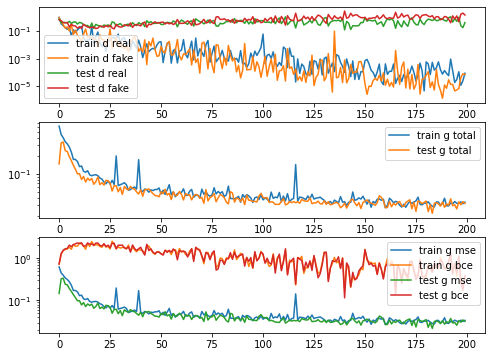

In [11]:
fig, ax = pl.subplots(3,1, figsize = (8,6))
ax[0].plot(train_loss[0,:], label = 'train d real')
ax[0].plot(train_loss[1,:], label = 'train d fake')

ax[1].plot(train_loss[2,:], label = 'train g total')

ax[2].plot(train_loss[3,:], label = 'train g mse')
ax[2].plot(train_loss[4,:], label = 'train g bce')


ax[0].plot(test_loss[0,:], label = 'test d real')
ax[0].plot(test_loss[1,:], label = 'test d fake')

ax[1].plot(test_loss[2,:], label = 'test g total')

ax[2].plot(test_loss[3,:], label = 'test g mse')
ax[2].plot(test_loss[4,:], label = 'test g bce')


ax[0].set_yscale('log')
ax[1].set_yscale('log')
ax[2].set_yscale('log')

ax[0].legend()
ax[1].legend()
ax[2].legend()

## Plot some of the generated examples 

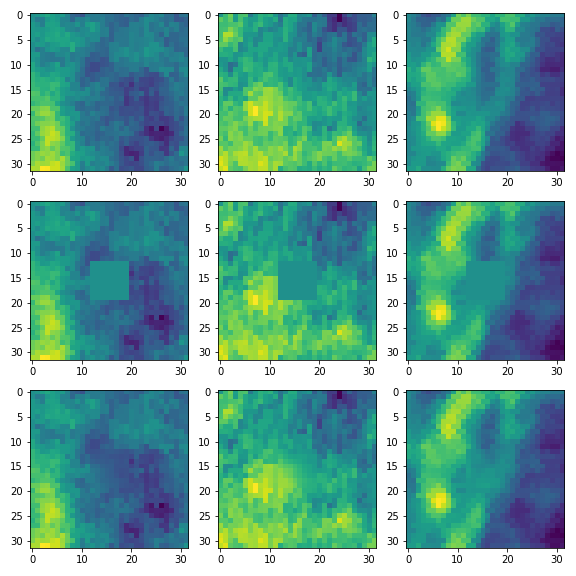

In [22]:
from IPython.display import Image 
Image("./network_output/images/9950.png")
#Image("./network_output/images/4500.png")

## Compute statistics on generated images

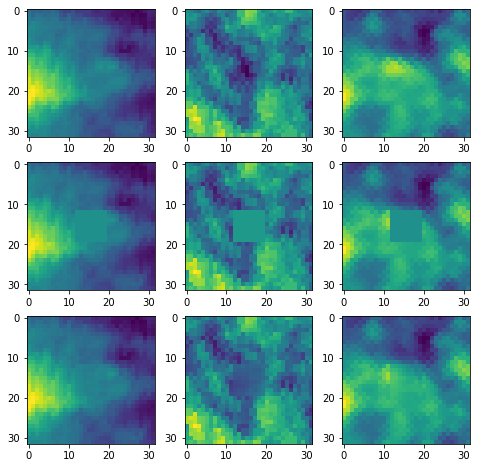

In [100]:
small_region = 4 #dimensions of tiny region over which we want to estimate backgrounds

def get_truth(imgs):
    
    img_size = imgs.shape[1]
    img_center = img_size/2
    
    low_small = int(img_center-small_region/2)
    high_small = int(img_center+small_region/2)
    true_small = np.mean(np.exp(imgs[:,low_small:high_small,low_small:high_small]), axis = (1,2))
    true_var_small = np.var(np.exp(imgs[:,low_small:high_small,low_small:high_small]), axis = (1,2))
    
    return true_small, true_var_small
    
def get_aperture_estimate(imgs):
    #print(imgs.shape)
    img_size = imgs.shape[1]
    img_center = img_size/2    
    
    aperture_min_size = 8
    aperture_max_size = 12
    aperture_loc_map = np.zeros((imgs.shape[1],imgs.shape[2]))

    low_min = int(img_center-aperture_min_size/2)
    high_min = int(img_center+aperture_min_size/2)
    low_max = int(img_center-aperture_max_size/2)
    high_max = int(img_center+aperture_max_size/2)

    aperture_loc_map[low_max:high_max,low_max:high_max] = 1
    aperture_loc_map[low_min:high_min,low_min:high_min] = 2
    
    #fig, ax = pl.subplots(1,1)
    #ax.imshow(aperture_loc_map)
    
    aperture_indices = np.where(aperture_loc_map == 2)
    aperture_estimate = np.zeros((imgs.shape[0],2))
    aperture_var_estimate = np.zeros((imgs.shape[0],2))
    for ii in range(imgs.shape[0]):
        mean0 = np.mean(np.exp(imgs[ii,:,:,0][aperture_indices]))
        mean1 = np.mean(np.exp(imgs[ii,:,:,1][aperture_indices]))
        var0 = np.var(np.exp(imgs[ii,:,:,0][aperture_indices]))
        var1 = np.var(np.exp(imgs[ii,:,:,1][aperture_indices]))        

        aperture_estimate[ii,0] = mean0
        aperture_estimate[ii,1] = mean1
        aperture_var_estimate[ii,0] = var0
        aperture_var_estimate[ii,1] = var1
    
    return aperture_estimate, aperture_var_estimate
    
num_samples = 500

idx = np.random.randint(0, cutouts_test.shape[0], num_samples)
imgs = cutouts_test[idx]

#Truth and aperture estimate
truth, truth_var = get_truth(imgs)
aperture_estimate, aperture_var_estimate = get_aperture_estimate(imgs)

#Mask images
masked_imgs, missing_parts, (y1, y2, x1, x2), min_outsidemask, max_outsidemask = context_encoder.mask_center(imgs)

# Generate a batch of new images
gen_missing = context_encoder.generator.predict(masked_imgs)

# rescale appropriately
gen_missing_rescaled = np.zeros(gen_missing.shape)
for ii in range(0,imgs.shape[0]):
    for ci in range(0,2):
        minval = min_outsidemask[ii, ci] 
        maxval = max_outsidemask[ii, ci]
        therange = (maxval - minval)
        gen_missing_rescaled[ii,:,:,ci] = minval + (gen_missing[ii,:,:,ci] + 1.)*0.5*therange    
        
#True value from nn
nn_estimate, nn_var_estimate = get_truth(gen_missing_rescaled)

r,c = 3,3
fig, axs = plt.subplots(r, c, figsize = (8,8))
for i in range(c):
    channel_plot = 1
    vmin = np.min(imgs[i, :,:,channel_plot])
    vmax = np.max(imgs[i, :,:,channel_plot])

    #Original
    axs[0,i].imshow(imgs[i, :,:,channel_plot], vmin = vmin, vmax = vmax)

    #masked
    minval = min_outsidemask[i, channel_plot] 
    maxval = max_outsidemask[i,channel_plot]
    therange = (maxval - minval)
    rescaled_masked = minval + (masked_imgs[i, :, :,channel_plot] + 1.)*0.5*therange    
    axs[1,i].imshow(rescaled_masked, vmin = vmin, vmax = vmax)

    #filled in
    filled_in = imgs[i,:,:,channel_plot].copy()
    #rescaled_gen_missing = minval + (gen_missing[i,:,:,channel_plot] + 1.)*0.5*therange    
    filled_in[y1:y2, x1:x2] = gen_missing_rescaled[i,:,:,channel_plot] #rescaled_gen_missing
    axs[2,i].imshow(filled_in, vmin = vmin, vmax = vmax)




(-5.0, 5.0)

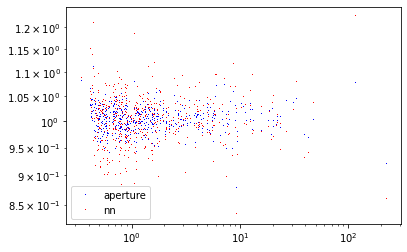

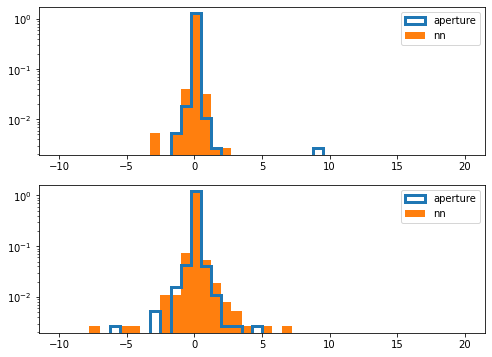

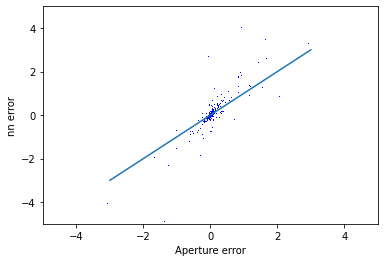

In [101]:
fig, ax = pl.subplots(1,1)
ax.plot(truth[:,0], aperture_estimate[:,0]/truth[:,0], 'b,', label = 'aperture')
ax.plot(truth[:,0], nn_estimate[:,0]/truth[:,0], 'r,', label = 'nn')
ax.legend()
ax.set_xscale('log')
ax.set_yscale('log')



nbins = 40
fig, ax = pl.subplots(2,1, figsize = (8,6))
ax[0].hist(aperture_estimate[:,0] - truth[:,0], density = True, label = 'aperture', bins = nbins, histtype = 'step', lw = 3, range = (-10,20))
ax[0].hist(nn_estimate[:,0] - truth[:,0], density = True, label = 'nn', bins = nbins, range = (-10,20))
ax[0].set_yscale('log')

ax[1].hist(aperture_estimate[:,1] - truth[:,1], density = True, label = 'aperture', bins = nbins, histtype = 'step', lw = 3, range = (-10,20))
ax[1].hist(nn_estimate[:,1] - truth[:,1], density = True, label = 'nn', bins = nbins, range = (-10,20))
ax[1].set_yscale('log')

ax[0].legend()
ax[1].legend()

fig, ax = pl.subplots(1,1)
ax.plot(aperture_estimate[:,1] - truth[:,1], nn_estimate[:,1] - truth[:,1], 'b,')
ax.set_xlabel('Aperture error')
ax.set_ylabel('nn error')
ax.plot([-3,3],[-3,3])
#ax.set_xlim((-0.2, 0.2))
#ax.set_ylim((-0.2, 0.2))
ax.set_xlim((-5., 5.))
ax.set_ylim((-5., 5.))




(-5.0, 5.0)

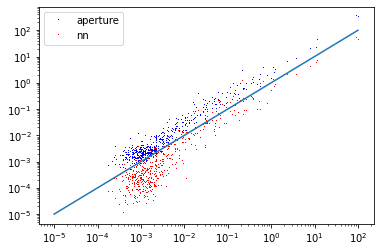

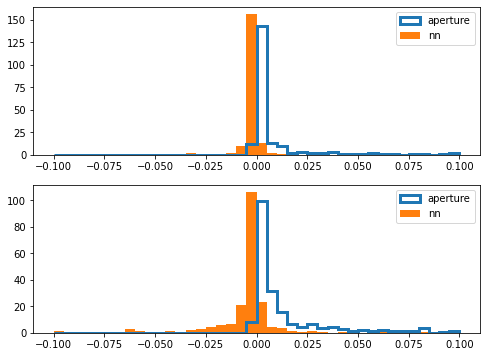

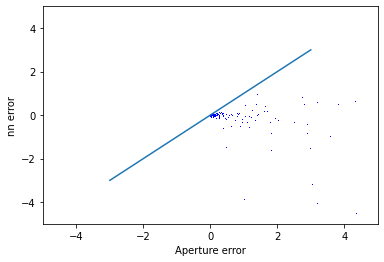

In [108]:
fig, ax = pl.subplots(1,1)
ax.plot(truth_var[:,0], aperture_var_estimate[:,0], 'b,', label = 'aperture')
ax.plot(truth_var[:,0], nn_var_estimate[:,0], 'r,', label = 'nn')
ax.plot((1.0e-5, 1.0e2), (1.0e-5, 1.0e2))
ax.legend()
ax.set_xscale('log')
ax.set_yscale('log')



nbins = 40
fig, ax = pl.subplots(2,1, figsize = (8,6))
ax[0].hist(aperture_var_estimate[:,0] - truth_var[:,0], density = True, label = 'aperture', bins = nbins, histtype = 'step', lw = 3, range = (-0.1,0.1))
ax[0].hist(nn_var_estimate[:,0] - truth_var[:,0], density = True, label = 'nn', bins = nbins, range = (-0.1,0.1))
#ax[0].set_yscale('log')

ax[1].hist(aperture_var_estimate[:,1] - truth_var[:,1], density = True, label = 'aperture', bins = nbins, histtype = 'step', lw = 3, range = (-0.1,0.1))
ax[1].hist(nn_var_estimate[:,1] - truth_var[:,1], density = True, label = 'nn', bins = nbins, range = (-0.1,0.1))
#ax[1].set_yscale('log')

ax[0].legend()
ax[1].legend()

fig, ax = pl.subplots(1,1)
ax.plot(aperture_var_estimate[:,1] - truth_var[:,1], nn_var_estimate[:,1] - truth_var[:,1], 'b,')
ax.set_xlabel('Aperture error')
ax.set_ylabel('nn error')
ax.plot([-3,3],[-3,3])
#ax.set_xlim((-0.2, 0.2))
#ax.set_ylim((-0.2, 0.2))
ax.set_xlim((-5., 5.))
ax.set_ylim((-5., 5.))


